## Failure ratio of master jobs
Jobs initiated in a period of one day over the last 90 days

In [1]:
%matplotlib inline
import sys
import os
import datetime, calendar
import azure.cosmos.cosmos_client as cosmos_client
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
client = cosmos_client.CosmosClient(url_connection=os.environ['endpoint'], auth={'masterKey': os.environ['masterKey']})

database_link = 'dbs/' + os.environ['databaseId']
collection_link = database_link + '/colls/{}'.format(os.environ['containerId'])

In [3]:
today = datetime.date.today()
one_day = datetime.timedelta(days=1)
one_week = datetime.timedelta(days=7)
    
# Number of days we want to go back in
days_in_past = 90
    
reversed_last_days = list(
    map(
        lambda i: (today - (i * one_day)).isoformat(),
        range(days_in_past + 1)
    )
)

last_days = reversed_last_days[::-1]

first_day, *tail_days = last_days

query = {
    "query": """
     SELECT c.job_name, c.build_id, c.current_build_current_result, c.stage_timestamp, c._ts
     FROM c
     WHERE c.current_build_scheduled_time > '{0}00:01:00.000Z'
         and c.branch_name = 'master'
    """.format(first_day)
}

query_results = list(client.QueryItems(collection_link, query))

df = pd.DataFrame(query_results)

In [4]:
def day_builds(week_df):
    return pd.DataFrame(
        week_df
            .sort_values(by='stage_timestamp')
            .drop_duplicates('job_name', keep='last')
    )

def day_df(frame, day_number):
    return frame[
        (frame['stage_timestamp'] > last_days[day_number])
        & (frame['stage_timestamp'] < last_days[day_number + 1])
    ]

builds = list(
    map(
        lambda day_number: day_builds(day_df(df, day_number)),
        list(range(len(last_days) - 1))
    )
)

In [5]:
def day_stats(i, current_build):
    total_rows = len(current_build)
    successes = len(current_build.loc[df['current_build_current_result'] == 'SUCCESS'])
    failures = len(current_build.loc[df['current_build_current_result'] == 'FAILURE'])
    aborted = len(current_build.loc[df['current_build_current_result'] == 'ABORTED'])
    unknows = total_rows - successes - failures - aborted
    total = successes + failures + aborted
    success_ratio = 100 if total == 0 else round(successes/total * 100)
    
    return ({
        "success ratio": success_ratio,
        "stats": [successes, failures, aborted, unknows],
        "stats_labels": ['SUCCESS', 'FAILURE', 'ABORTED', 'UNKNOWN'],
        "date": { "from": last_days[i], "to" : last_days[i+1] }
    })

all_days_stats = [day_stats(i,x) for i,x in enumerate(builds)]

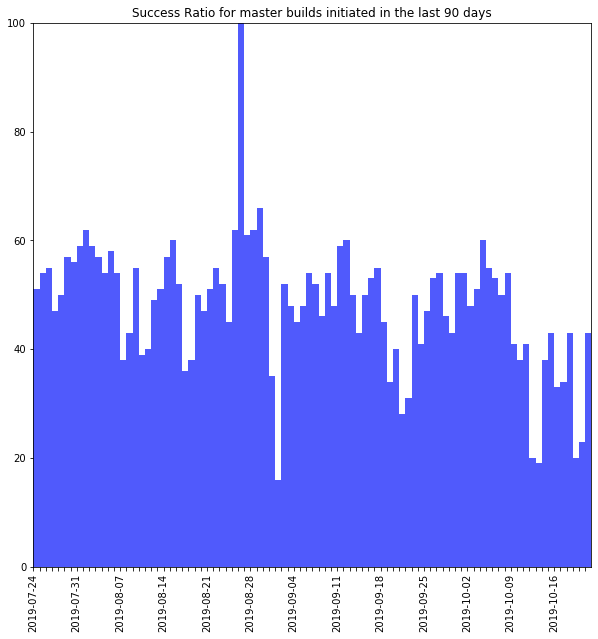

In [15]:
success_ratios = list(
    map(
        lambda all_days_stats: all_days_stats['success ratio'],
        all_days_stats
    )
)

horizontal_axis_labels = list(
    map(
        lambda all_days_stats: all_days_stats['date']['from'],
        all_days_stats
    )
)

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.set_title('Success Ratio for master builds initiated in the last {0} days'.format(days_in_past))
ax.margins(0)
plt.bar(list(range(days_in_past)), success_ratios, linewidth=2, color='#505AFC', align='edge', width=1)
plt.xticks(range(days_in_past), horizontal_axis_labels, rotation='vertical')
plt.ylim(top=100, bottom=0)

every_nth = 7
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.show()